#Prequisites
Please install Python and required libraries for this exercise, or do it in google colab.

We recommend that you use either [PyTorch](https://pytorch.org/get-started/locally/) or [TensorFlow](https://www.tensorflow.org/learn)

The import statements of the solution we prepared are specified below, however feel free to use any other library.


## Data
The data is gained from sequencing data of the microbiome in humans colon. Basically different DNA fragments can be matched to the same species due to high variety of bacterial DNA, so starting from sequencing data of the complete mix of bacterial species from the colon, different fragments are matched to species Pan-genomes to identify different species.
In the processing, the sequences were mapped to bacteria species and normalized such that , these values describe a normalized quantitative measure.
Additionally, the following columns are provided:
- the first column is just an index generated in pseudoanonymization
- health status: 0 is healthy, 1 is colorectal cancer
- gender: 0 is female, 1 is male
- bmi is the body mass index
- age is, well, age

In [62]:
# We used these packages for our solution, you might use others
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

from sklearn.linear_model import LogisticRegression

#1)
Read in the data and perform any cleaning you find necessary. You don't have to do any normalization. (2 points)

In [ ]:
# Read the data

# Do any data cleaning you feel is necessary (data is normalized already)
df = pd.read_csv('../data/microbiome_exercise_data.csv')
df.head(3)

,Unnamed: 0,health_status,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,...,Pseudomonas_phage_LBL3,Pseudomonas_phage_JG024,Corynebacterium_pyruviciproducens,Streptococcus_uberis,Pasteurella_unclassified,Propionibacterium_phage_P14_4,Comamonas_testosteroni,Lactobacillus_phage_J_1,Klebsiella_phage_KP15,Enterobacteria_phage_vB_EcoM_FV3
0,ERS848618,1,23.1,64.0,1,18.03870,0.00000,0.15574,0.36315,0.00310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ERS848619,1,23.8,73.0,1,0.27448,0.88600,0.00000,0.00000,0.06824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ERS848620,1,24.7,67.0,0,0.48998,0.04594,0.08130,0.00499,0.00472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.set_index('Unnamed: 0', inplace=True)

In [9]:
df.head(3)

,health_status,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,Eubacterium_rectale,...,Pseudomonas_phage_LBL3,Pseudomonas_phage_JG024,Corynebacterium_pyruviciproducens,Streptococcus_uberis,Pasteurella_unclassified,Propionibacterium_phage_P14_4,Comamonas_testosteroni,Lactobacillus_phage_J_1,Klebsiella_phage_KP15,Enterobacteria_phage_vB_EcoM_FV3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ERS848618,1,23.1,64.0,1,18.03870,0.00000,0.15574,0.36315,0.00310,1.74664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848619,1,23.8,73.0,1,0.27448,0.88600,0.00000,0.00000,0.06824,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848620,1,24.7,67.0,0,0.48998,0.04594,0.08130,0.00499,0.00472,0.02017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df.describe()

,health_status,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,Eubacterium_rectale,...,Pseudomonas_phage_LBL3,Pseudomonas_phage_JG024,Corynebacterium_pyruviciproducens,Streptococcus_uberis,Pasteurella_unclassified,Propionibacterium_phage_P14_4,Comamonas_testosteroni,Lactobacillus_phage_J_1,Klebsiella_phage_KP15,Enterobacteria_phage_vB_EcoM_FV3
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,...,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0
mean,0.518182,23.846364,63.927273,0.636364,5.911588,1.189342,0.122323,0.370020,0.298891,3.629518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.501956,3.151807,9.026677,0.483247,15.048243,3.961439,0.295851,1.125486,0.843017,6.287427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,17.100000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,21.900000,58.000000,0.000000,0.115095,0.003477,0.000000,0.000000,0.010955,0.006357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.000000,23.600000,64.000000,1.000000,0.528100,0.082075,0.000000,0.000000,0.050295,0.806525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,25.600000,69.750000,1.000000,2.251453,0.665038,0.051280,0.165450,0.209172,4.874162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,35.100000,89.000000,1.000000,86.680610,36.611540,1.774820,8.777070,7.645520,35.445530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df.isnull().sum()

health_status                       0
bmi                                 0
age                                 0
gender                              0
Escherichia_coli                    0
                                   ..
Propionibacterium_phage_P14_4       0
Comamonas_testosteroni              0
Lactobacillus_phage_J_1             0
Klebsiella_phage_KP15               0
Enterobacteria_phage_vB_EcoM_FV3    0
Length: 887, dtype: int64

# 2)
Prepare two heatmaps of the data, one of health_status = 0, the other of health_status = 1. (2 points)

You don't have to worry about the column_names overlapping, we just want a quick overview.

In [15]:
df_0 = df[df['health_status'] == 0]
df_1 = df[df['health_status'] == 1]
# drop any non-numeric columns
columns = df.select_dtypes(include=['float64', 'int64']).columns
df_0 = df_0[columns]
df_1 = df_1[columns]

In [35]:
corr_0 = df_0.corr(numeric_only=True).dropna(how='all').dropna(axis=1, how='all')
corr_0


,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,Eubacterium_rectale,Alistipes_shahii,...,Corynebacterium_variabile,Shigella_sonnei,Avian_endogenous_retrovirus_EAV_HP,Enterobacter_hormaechei,Shigella_phage_pSf_1,Acinetobacter_baumannii,Macrococcus_caseolyticus,Clostridium_sp_HGF2,Yersinia_enterocolitica,Sodalis_glossinidius
bmi,1.000000,-0.018314,-0.042485,-0.015412,-0.096290,0.152931,-0.026349,-0.165331,0.211147,0.139876,...,0.013695,0.136240,-0.069574,0.111183,0.056115,0.065541,-0.038151,-0.094710,0.131527,0.013695
age,-0.018314,1.000000,-0.527385,0.206836,-0.061503,-0.012336,0.018139,0.152224,-0.076310,0.123451,...,-0.017573,-0.164627,-0.131393,0.026830,0.055955,0.153991,0.055955,-0.017573,-0.091100,-0.017573
gender,-0.042485,-0.527385,1.000000,-0.273176,0.114413,0.221081,-0.177021,-0.237984,0.053595,0.070097,...,0.107958,0.107958,0.031448,-0.162439,0.107958,-0.178131,-0.178131,0.107958,0.107958,0.107958
Escherichia_coli,-0.015412,0.206836,-0.273176,1.000000,-0.101286,-0.173093,-0.085316,0.423141,-0.032919,-0.075764,...,-0.061693,-0.051191,-0.075266,-0.035143,-0.003131,-0.027988,-0.006646,-0.056949,-0.062369,-0.061693
Ruminococcus_gnavus,-0.096290,-0.061503,0.114413,-0.101286,1.000000,0.010753,-0.108552,0.178708,-0.205467,-0.145513,...,-0.052654,-0.033445,0.662398,-0.059169,-0.008526,-0.052654,-0.052654,0.088539,-0.052615,-0.052654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Acinetobacter_baumannii,0.065541,0.153991,-0.178131,-0.027988,-0.052654,-0.062616,-0.042992,-0.037351,-0.009710,-0.010736,...,-0.019231,-0.019231,-0.025317,-0.021694,-0.019231,1.000000,-0.019231,-0.019231,-0.019231,-0.019231
Macrococcus_caseolyticus,-0.038151,0.055955,-0.178131,-0.006646,-0.052654,-0.036898,-0.042992,-0.041621,0.131410,-0.063483,...,-0.019231,-0.019231,-0.025317,-0.021694,-0.019231,-0.019231,1.000000,-0.019231,-0.019231,-0.019231
Clostridium_sp_HGF2,-0.094710,-0.017573,0.107958,-0.056949,0.088539,-0.062616,-0.042992,0.433008,-0.094777,-0.056869,...,-0.019231,-0.019231,-0.025317,-0.021694,-0.019231,-0.019231,-0.019231,1.000000,-0.019231,-0.019231
Yersinia_enterocolitica,0.131527,-0.091100,0.107958,-0.062369,-0.052615,-0.062616,-0.042992,-0.057898,0.078509,-0.063483,...,-0.019231,-0.019231,-0.025317,-0.021694,-0.019231,-0.019231,-0.019231,-0.019231,1.000000,-0.019231


In [36]:
corr_1 = df_1.corr(numeric_only=True).dropna(how='all').dropna(axis=1, how='all')
corr_1

,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,Eubacterium_rectale,Alistipes_shahii,...,Escherichia_phage_N4,Eubacterium_yurii,Enterobacteria_phage_HK544,Klebsiella_phage_KP36,Torque_teno_virus,Viunalikevirus_unclassified,Human_adenovirus_D,Desulfovibrio_termitidis,Lactococcus_phage_asccphi28,Anaerococcus_tetradius
bmi,1.000000,0.047674,-0.171673,-0.053892,0.235006,-0.095091,-0.323012,0.283948,0.350214,-0.141028,...,-0.043201,-0.043201,0.022030,-0.105860,-0.059509,-0.120663,-0.088048,0.156569,0.030184,0.030184
age,0.047674,1.000000,-0.096236,0.113579,-0.112858,-0.041946,-0.245939,0.102496,0.220221,-0.096501,...,-0.024462,-0.024462,0.012556,0.230751,-0.049141,0.061913,0.135950,-0.036802,0.012556,0.012556
gender,-0.171673,-0.096236,1.000000,0.157958,-0.117374,-0.280813,0.146125,-0.254213,-0.113884,0.000606,...,0.098247,0.098247,-0.181757,-0.258173,0.098247,-0.181757,0.098247,-0.181757,0.098247,0.098247
Escherichia_coli,-0.053892,0.113579,0.157958,1.000000,0.030752,-0.105303,-0.103475,-0.054107,-0.084963,-0.134229,...,0.128555,0.128555,-0.040715,0.051343,-0.045240,-0.042864,0.093717,-0.042373,0.430167,0.430167
Ruminococcus_gnavus,0.235006,-0.112858,-0.117374,0.030752,1.000000,-0.130554,-0.119243,0.030797,0.185907,-0.188910,...,-0.040569,-0.040569,-0.039351,-0.036340,-0.040569,-0.024738,0.192654,-0.039889,-0.014613,-0.014613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Viunalikevirus_unclassified,-0.120663,0.061913,-0.181757,-0.042864,-0.024738,-0.065897,-0.010628,0.003325,-0.067281,0.035392,...,-0.017857,-0.017857,-0.017857,0.765983,-0.017857,1.000000,-0.017857,-0.017857,-0.017857,-0.017857
Human_adenovirus_D,-0.088048,0.135950,0.098247,0.093717,0.192654,-0.065897,-0.053805,-0.045829,0.004795,-0.091706,...,-0.017857,-0.017857,-0.017857,-0.025365,-0.017857,-0.017857,1.000000,-0.017857,-0.017857,-0.017857
Desulfovibrio_termitidis,0.156569,-0.036802,-0.181757,-0.042373,-0.039889,-0.065897,-0.053925,0.018907,-0.039176,-0.036066,...,-0.017857,-0.017857,-0.017857,-0.025365,-0.017857,-0.017857,-0.017857,1.000000,-0.017857,-0.017857
Lactococcus_phage_asccphi28,0.030184,0.012556,0.098247,0.430167,-0.014613,-0.065897,-0.053925,-0.049789,-0.063358,-0.091706,...,-0.017857,-0.017857,-0.017857,-0.025365,-0.017857,-0.017857,-0.017857,-0.017857,1.000000,1.000000


<Axes: >

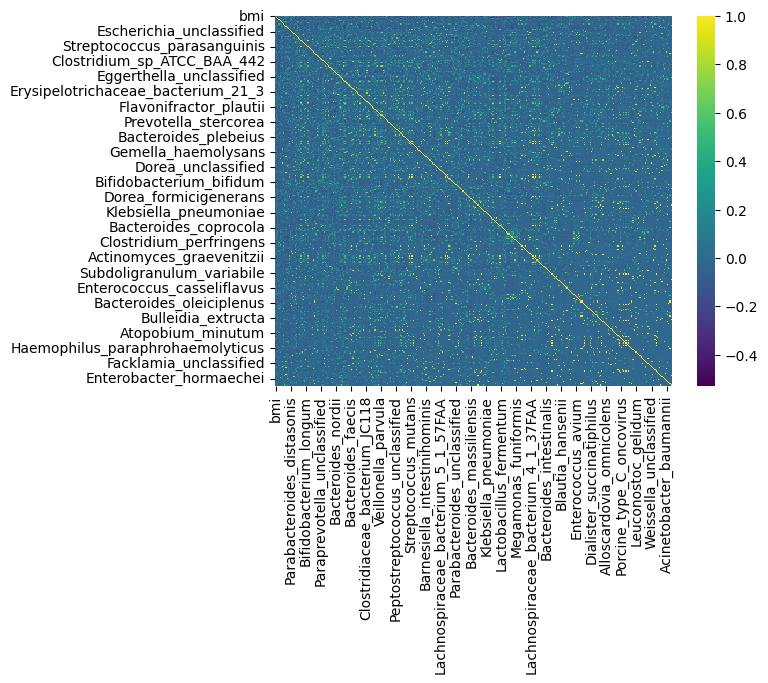

In [38]:
# Plot the heatmaps
sns.heatmap(corr_0, cmap='viridis')

<Axes: >

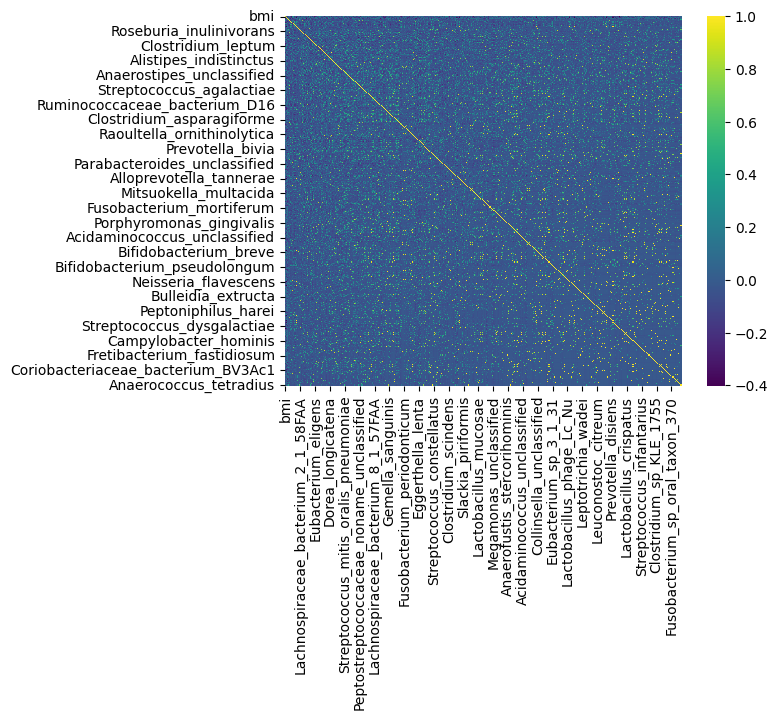

In [39]:
sns.heatmap(corr_1, cmap='viridis')

#3)
Plot the sample elements based on their bacteria abundances with PCA. (3 points)

In [40]:
# Your code here
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

bacterial_columns = df.columns[4:]
X_bacteria = df[bacterial_columns].values
X_bacteria

array([[1.803870e+01, 0.000000e+00, 1.557400e-01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.744800e-01, 8.860000e-01, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [4.899800e-01, 4.594000e-02, 8.130000e-02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.020136e+01, 8.524700e-01, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.365000e-02, 0.000000e+00, 1.280000e-02, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [4.268460e+00, 2.634500e-01, 2.690000e-03, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], shape=(110, 883))

In [41]:
# Standardize the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bacteria)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [48]:
sns.set_theme(style="whitegrid")

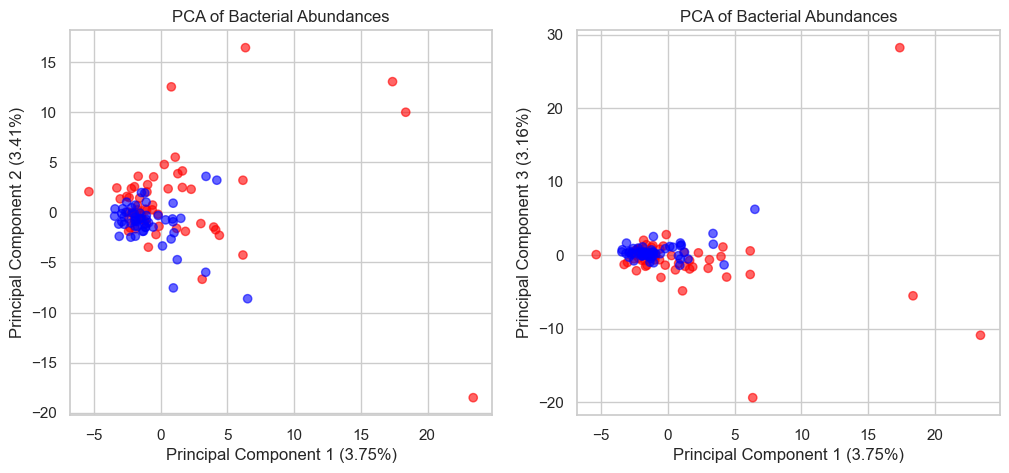

In [49]:
# Creating the plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['blue' if x == 0 else 'red' for x in df['health_status']]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA of Bacterial Abundances')

# Second plot
# PC1 vs PC3
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 2], c=colors, alpha=0.6)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.2%})')
plt.title('PCA of Bacterial Abundances')


plt.show()

#4)
Train a MLP(Multilayer Perceptron) on the data to classify the health_status based on the given variables/features. We provide you the main part of the implementation.

Your task is to calculate and print the training and testing losses and accuracies over the epochs.

(4 points)


In [53]:
len(df.columns)

887

In [51]:
df = pd.read_csv('../data/microbiome_exercise_data.csv', index_col=0)
df.head()

,health_status,bmi,age,gender,Escherichia_coli,Ruminococcus_gnavus,Alistipes_finegoldii,Eubacterium_siraeum,Clostridium_bolteae,Eubacterium_rectale,...,Pseudomonas_phage_LBL3,Pseudomonas_phage_JG024,Corynebacterium_pyruviciproducens,Streptococcus_uberis,Pasteurella_unclassified,Propionibacterium_phage_P14_4,Comamonas_testosteroni,Lactobacillus_phage_J_1,Klebsiella_phage_KP15,Enterobacteria_phage_vB_EcoM_FV3
ERS848618,1,23.1,64.0,1,18.03870,0.00000,0.15574,0.36315,0.00310,1.74664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848619,1,23.8,73.0,1,0.27448,0.88600,0.00000,0.00000,0.06824,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848620,1,24.7,67.0,0,0.48998,0.04594,0.08130,0.00499,0.00472,0.02017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848621,1,25.6,56.0,1,0.92945,0.71337,0.00530,0.00000,0.14374,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERS848622,1,20.7,59.0,0,0.32502,0.08828,1.15053,2.46302,0.09166,1.43800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
len(df.select_dtypes(include=['float64', 'int64']).columns)

887

In [55]:
# Drop irrelevant columns
cols_to_drop = []

for col in df.columns:
    if df[col].min() == df[col].max():
        cols_to_drop.append(col)

df = df.drop(cols_to_drop, axis=1)
print(f"Dropped {len(cols_to_drop)} columns")
df.head()
len(df.columns)

Dropped 449 columns


438

In [57]:
# Extract features and target labels
X = df.drop('health_status', axis=1).values
y = df['health_status'].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=9)

n_features = len
# Define the neural network
model = nn.Sequential(
    nn.Linear(437, 50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(50, 2),
    nn.Softmax(dim=1)  # Specify the dimension for softmax
)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.inference_mode():
        model.eval()
        _, predicted_train = torch.max(outputs, 1)
        # Your code - calculate training accuracy
        
        train_accuracy = accuracy_score(y_train, predicted_train)


        # Evaluate on the test set
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs, 1)
        # Your code - calculate test accuracy
        test_accuracy = accuracy_score(y_test, predicted_test)
    if (epoch+1) % 100 == 0:
        # Your code
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 100/1000, Loss: 0.6217, Training Accuracy: 0.6591, Test Accuracy: 0.7273
Epoch 200/1000, Loss: 0.5692, Training Accuracy: 0.8068, Test Accuracy: 0.5909
Epoch 300/1000, Loss: 0.5221, Training Accuracy: 0.8068, Test Accuracy: 0.5909
Epoch 400/1000, Loss: 0.4883, Training Accuracy: 0.8409, Test Accuracy: 0.5909
Epoch 500/1000, Loss: 0.4535, Training Accuracy: 0.9091, Test Accuracy: 0.6364
Epoch 600/1000, Loss: 0.4496, Training Accuracy: 0.8977, Test Accuracy: 0.6364
Epoch 700/1000, Loss: 0.4152, Training Accuracy: 0.9205, Test Accuracy: 0.6364
Epoch 800/1000, Loss: 0.4081, Training Accuracy: 0.9205, Test Accuracy: 0.6364
Epoch 900/1000, Loss: 0.3960, Training Accuracy: 0.9318, Test Accuracy: 0.5909
Epoch 1000/1000, Loss: 0.3879, Training Accuracy: 0.9432, Test Accuracy: 0.6818


#5)
Calculate the accuracy and AUC for the test set. Also plot the ROC (3 points)

Your model should have around 60% or more accuracy. In some random splits you might get lower results, for this exercise just rerun the training in that case.

Test Accuracy: 0.6818
Test AUC: 0.7778


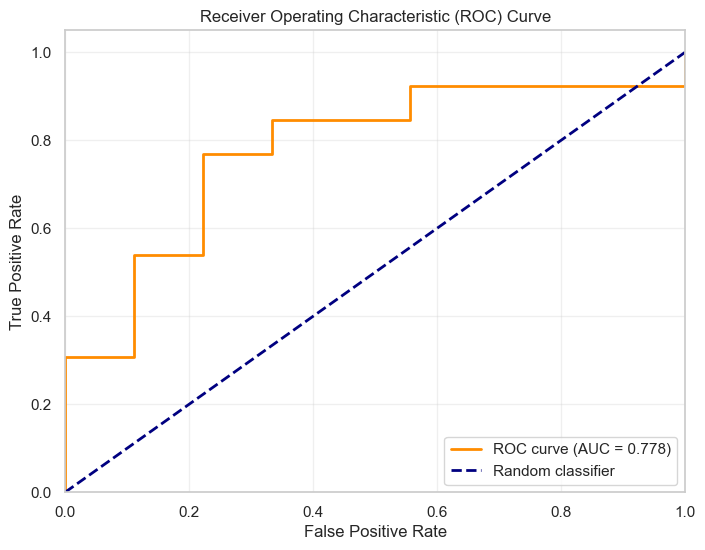

In [ ]:
# Calculate performance metrics here
model.eval()


with torch.inference_mode():
    test_outputs = model(X_test)
    test_probabilities = test_outputs[:, 1] # Get probabilities for class 1 : cancer
    test_predictions = torch.argmax(test_outputs, dim=1)

# COnvert to numpy
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.numpy()
test_probabilities_np = test_probabilities.numpy()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_np, test_predictions_np)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate AUC
test_auc = roc_auc_score(y_test_np, test_probabilities_np)
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_np, test_probabilities_np)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


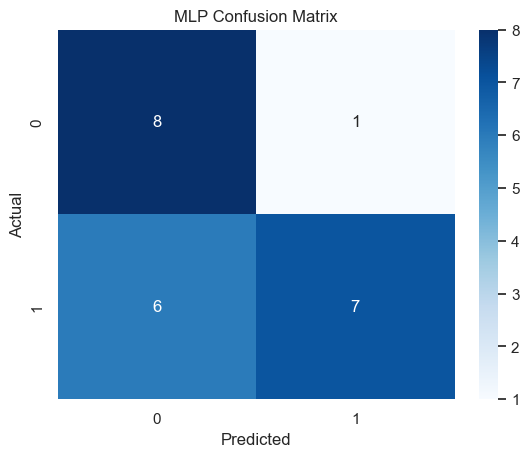

In [64]:
# COnfusion matrix 
mlp_cm = confusion_matrix(y_test_np, test_predictions_np)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#6)
Train a logistic regression classifier using the same data split and evaluation approach. Compare the performance of both models. (5 points)

In [60]:
# Train the logistic regression classifier here
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression classifier
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the same training data used for MLP
logistic_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully!")
print(f"Model parameters: {logistic_model.get_params()}")

Logistic Regression model trained successfully!
Model parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


MODEL COMPARISON RESULTS
MLP Accuracy: 0.6818
Logistic Regression Accuracy: 0.7727
Accuracy Difference: 0.0909

MLP AUC: 0.7778
Logistic Regression AUC: 0.7350
AUC Difference: 0.0427

Logistic Regression performs better in accuracy by 0.0909
MLP performs better in AUC by 0.0427


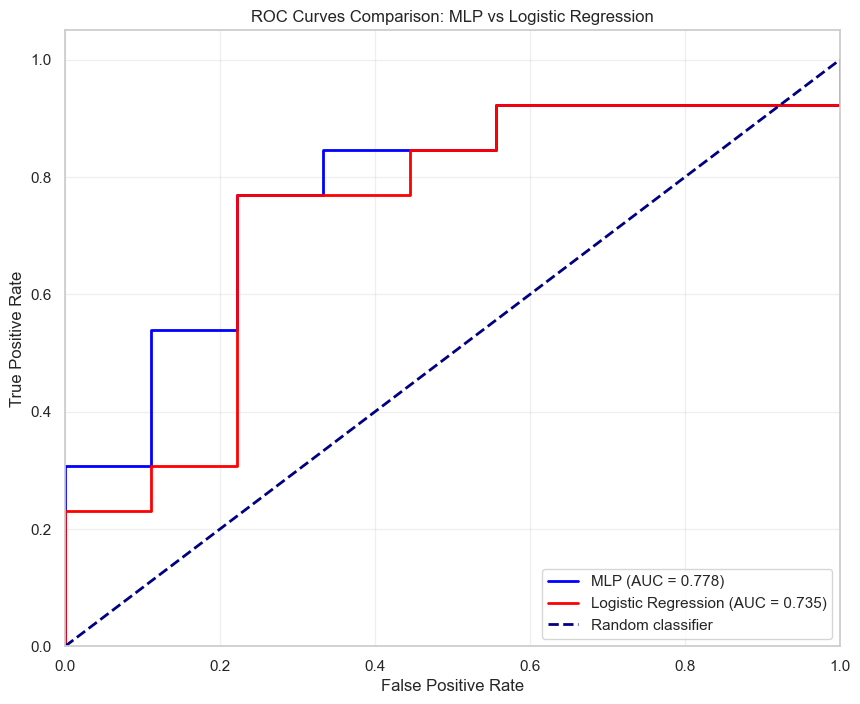

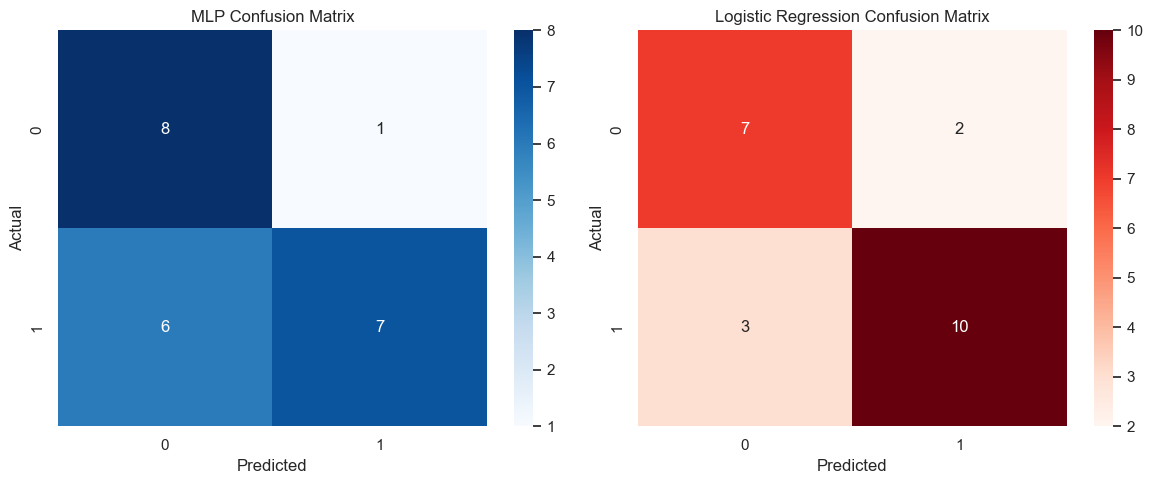


DETAILED CLASSIFICATION REPORTS

MLP Classification Report:
              precision    recall  f1-score   support

     Healthy       0.57      0.89      0.70         9
      Cancer       0.88      0.54      0.67        13

    accuracy                           0.68        22
   macro avg       0.72      0.71      0.68        22
weighted avg       0.75      0.68      0.68        22


Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Healthy       0.70      0.78      0.74         9
      Cancer       0.83      0.77      0.80        13

    accuracy                           0.77        22
   macro avg       0.77      0.77      0.77        22
weighted avg       0.78      0.77      0.77        22


SUMMARY COMPARISON TABLE
Metric               MLP        Logistic Regression  Difference
------------------------------------------------------------
Accuracy             0.6818     0.7727               0.0909    
AUC                  0.777

In [63]:
# Evaluate the logistic regression classifier here and compare to MLP

# Get predictions and probabilities from logistic regression
logistic_predictions = logistic_model.predict(X_test)
logistic_probabilities = logistic_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate metrics for logistic regression
logistic_accuracy = accuracy_score(y_test_np, logistic_predictions)
logistic_auc = roc_auc_score(y_test_np, logistic_probabilities)

print("="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)

# Print accuracy comparison
print(f"MLP Accuracy: {test_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {logistic_accuracy:.4f}")
print(f"Accuracy Difference: {abs(test_accuracy - logistic_accuracy):.4f}")

# Print AUC comparison
print(f"\nMLP AUC: {test_auc:.4f}")
print(f"Logistic Regression AUC: {logistic_auc:.4f}")
print(f"AUC Difference: {abs(test_auc - logistic_auc):.4f}")

# Determine which model performs better
if test_accuracy > logistic_accuracy:
    print(f"\nMLP performs better in accuracy by {test_accuracy - logistic_accuracy:.4f}")
elif logistic_accuracy > test_accuracy:
    print(f"\nLogistic Regression performs better in accuracy by {logistic_accuracy - test_accuracy:.4f}")
else:
    print("\nBoth models have the same accuracy")

if test_auc > logistic_auc:
    print(f"MLP performs better in AUC by {test_auc - logistic_auc:.4f}")
elif logistic_auc > test_auc:
    print(f"Logistic Regression performs better in AUC by {logistic_auc - test_auc:.4f}")
else:
    print("Both models have the same AUC")

# Plot ROC curves for both models
plt.figure(figsize=(10, 8))

# Calculate ROC curves
mlp_fpr, mlp_tpr, _ = roc_curve(y_test_np, test_probabilities_np)
lr_fpr, lr_tpr, _ = roc_curve(y_test_np, logistic_probabilities)

# Plot both ROC curves
plt.plot(mlp_fpr, mlp_tpr, color='blue', lw=2, label=f'MLP (AUC = {test_auc:.3f})')
plt.plot(lr_fpr, lr_tpr, color='red', lw=2, label=f'Logistic Regression (AUC = {logistic_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison: MLP vs Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Confusion matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# MLP Confusion Matrix
mlp_cm = confusion_matrix(y_test_np, test_predictions_np)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('MLP Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Logistic Regression Confusion Matrix
lr_cm = confusion_matrix(y_test_np, logistic_predictions)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Reds', ax=ax2)
ax2.set_title('Logistic Regression Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("\nMLP Classification Report:")
print(classification_report(y_test_np, test_predictions_np, target_names=['Healthy', 'Cancer']))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_np, logistic_predictions, target_names=['Healthy', 'Cancer']))

# Summary table
print("\n" + "="*60)
print("SUMMARY COMPARISON TABLE")
print("="*60)
print(f"{'Metric':<20} {'MLP':<10} {'Logistic Regression':<20} {'Difference':<10}")
print("-" * 60)
print(f"{'Accuracy':<20} {test_accuracy:<10.4f} {logistic_accuracy:<20.4f} {abs(test_accuracy - logistic_accuracy):<10.4f}")
print(f"{'AUC':<20} {test_auc:<10.4f} {logistic_auc:<20.4f} {abs(test_auc - logistic_auc):<10.4f}")